# Mixed carbon substrates tri-culture
Results from analysis of the tri-culture engineered to grow on glucose and xylose.
Consiting of constructs SAL11 (bl21 derived, grows on glucose), CAL11 (k12 derived, grows on xylose), and MAM3 (k12 derived, grows on xylose).

This notebook contains key numbers from the experimental data, static steady-state analysis of relative community member abundance and theoretical max rosmarinic acid (RA) production rate, dynamic simulation and time-course growth and production profiles, and comparison of inoculation ratio and substrate composition.

## Loading and preparing models

In [3]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

# load all models into reframed
CAL11 = load_cbmodel("GEMs/CAL11.xml", flavor="bigg")
SAL11 = load_cbmodel("GEMs/SAL11.xml", flavor="bigg")
MAM3 = load_cbmodel("GEMs/MAM3.xml", flavor="bigg")

# stop SAA module from looping by making the reactions one-way
SAL11.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
SAL11.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [4]:
# build community object
community = Community('RA_community', [CAL11, SAL11, MAM3])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(CAL11).apply(merged_community, exclusive=True, inplace=False)
# add xylose to the medium
medium["R_EX_xyl__D_e"] = (-8, float("inf"))

*NOTE*: glucose exchange lb is set to -10 and xylose to -8, in order to reflect the molar ratio of available glucose / xylose in the media (2 g/L xylose and 3 g/L glucose)

## Experimental results

In [5]:
import pandas as pd
import functions.data_analysis as data_analysis

# read data
relative_abundance_df = pd.read_csv("exp_data/subpop_data_xyl_glc.csv")
products_df = pd.read_csv("exp_data/conc_data_xyl_glc.csv")
od600_df = pd.read_csv("exp_data/od600_xyl_glc.csv")

subpop_df, conc_df, OD_df = data_analysis.process_data(relative_abundance_df, products_df, od600_df)

In [6]:
cal11_ra, sal11_ra, mam3_ra = data_analysis.get_relative_abundance_stats_triculture(subpop_df)

Relative SAl11 abundance at steady-state: 0.715428141
Relative CAL11 abundance at steady-state: 0.171697049
Relative MAM3 abundance at steady-state: 0.107159233


In [7]:
data_analysis.print_production_stats_triculture(conc_df)

Final RA concentration (mg/L): 171.8430034
Final RA amount (mmol): 0.047692463201622584
Final SAA concentration (mg/L): 34.81228669
Final SAA amount (mmol): 0.01756664096013225
Final CA concentration (mg/L): 59.55631399
Final CA amount (mmol): 0.03305793377901768


In [60]:
CA_yield, SAA_yield, RA_yield = data_analysis.get_yields_glc_xyl(conc_df)

CA yield 0.007273890784500001 g CA per g xylose
SAA yield 0.004310857623772064 g SAA per g glucose
RA yield 0.00859215017 g RA per g xylose


## Static simulation

### Theoretical RA production
using steadiercom

In [15]:
from reframed.community.simulation import simulate as SteadierCom

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", steadiercom_sim.values["R_EX_rosma_e"])
print(steadiercom_sim)

RA production rate:  4.126909975750305
Community growth: 0.1
CAL11	0.309715291089973
SAL11	0.6096645719132987
MAM3	0.0806201369967284


- SteadierCom scales the fluxes by the abundance of the species, and applies enzyme allocation constraints
- SteadierCom predicts production rate that is only about 0.1 lower than the FBA optimum solution
- relative abundance between community member that follows the same pattern as exp. data (SAL11 > CAL11 > MAM3) when maximising RA production
- Steadiercom predicts a max theoretical RA production rate of 4.13 mmol/h/gDW

### Relative species abundance

(steadycom, old)

In [42]:
from reframed import SteadyComVA
from tqdm.notebook import tqdm

results_list = []

for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=frac)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df.set_index("frac");

  0%|          | 0/11 [00:00<?, ?it/s]

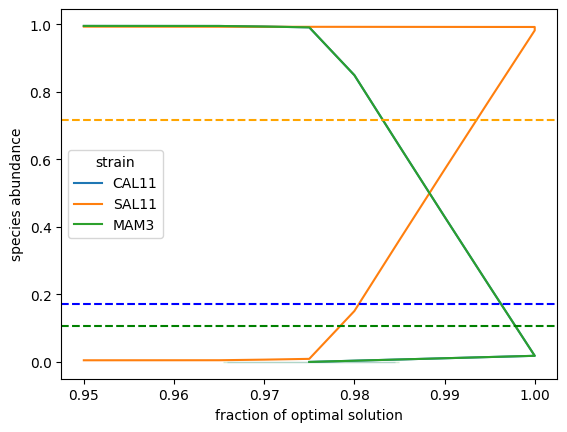

In [43]:
from functions.plot_results import plot_relative_abundance_glc_xyl

plot_relative_abundance_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra)

Using steadiercom:

In [44]:
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm

results_list = []

for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadierComFVA(community, constraints=medium, obj_frac=frac, allocation=True)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df.set_index("frac");

  0%|          | 0/11 [00:00<?, ?it/s]

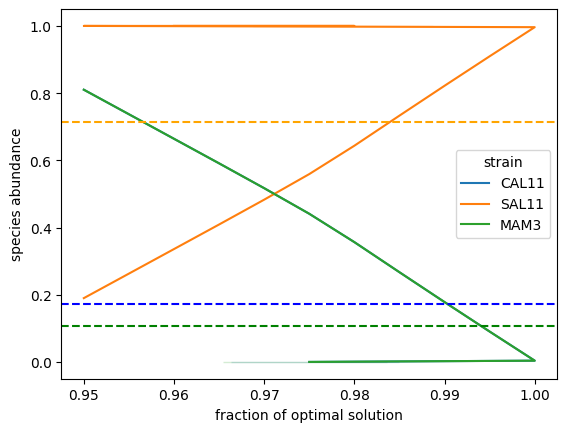

In [45]:
plot_relative_abundance_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra)

- CAL11 and MAM3 are completely overlapping, this is because there is no CA/RA production at optimum, and therefore the two models are identical
- the measured relative species abundance is within the FVA range at about 98.5% of optimum

In [9]:
from functions import updated_steadycom
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from reframed.community.simulation import simulate as SteadierCom

num_points = 11

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadyComVA(community, constraints=all_constraints, obj_frac=0.99)

    com_fva_solution["RA_prod_rate"] = RA_level
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df["RA_percentage"] = np.linspace(100, 0, num_points);

  0%|          | 0/11 [00:00<?, ?it/s]

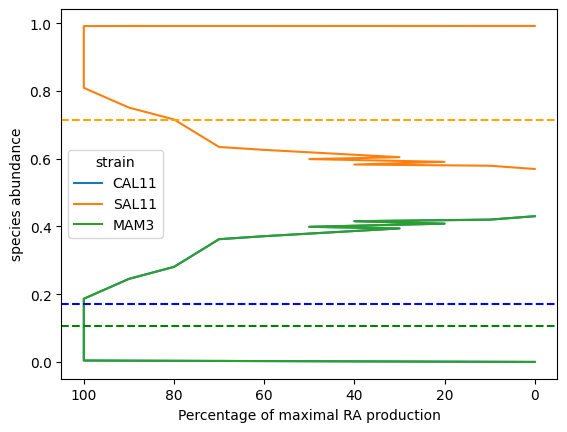

In [10]:
from functions.plot_results import plot_relative_abundance_RA_prod_glc_xyl

plot_relative_abundance_RA_prod_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra)

- above is steadycom not steadiercom, old, but keeping for comparison / history
- we see the problems of steadycom clearly, we can have almost 0 cal11/MAM3 beucase their production fluxes are so high

In [37]:
from reframed.community.simulation import simulate as SteadierCom
from functions.steadiercom import SteadierComFVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadierComFVA(community, constraints=all_constraints, obj_frac=0.95, allocation=True)

    com_fva_solution["RA_prod_rate"] = RA_level
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list);
results_df["RA_percentage"] = np.linspace(100, 0, num_points);

  0%|          | 0/11 [00:00<?, ?it/s]

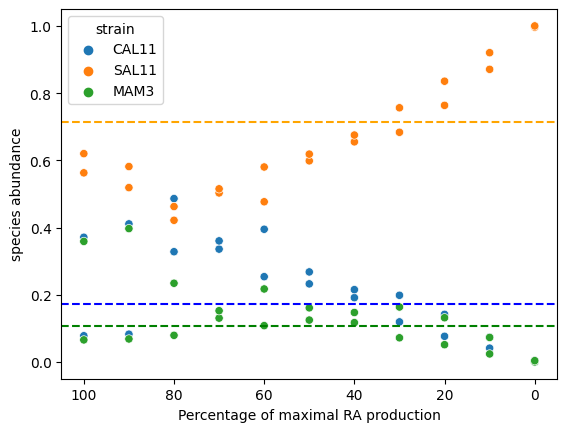

In [10]:
from functions.plot_results import plot_relative_abundance_RA_prod_glc_xyl

#this is for obj_frac = 1.0
plot_relative_abundance_RA_prod_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra, scatter=True)

- We can actually get the exact species distribution at aprox 30% of theoretical max RA production rate!
    - 4.126909975750305 * 0.3 = 1.23807299
    - when the community produces RA at a rate of 1.23807299, species abundance is equal to exp.

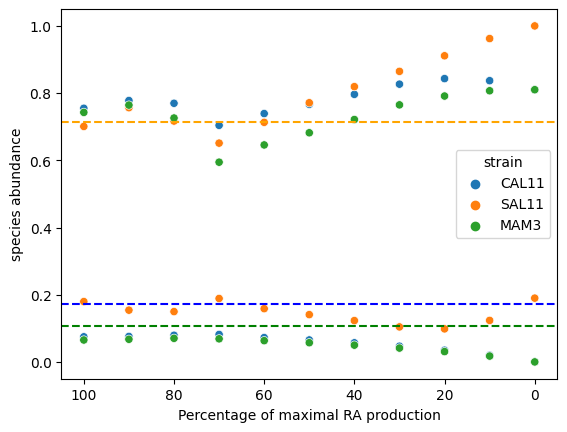

In [39]:
from functions.plot_results import plot_relative_abundance_RA_prod_glc_xyl

#this is for obj_frac = 0.95
plot_relative_abundance_RA_prod_glc_xyl(results_df, cal11_ra, sal11_ra, mam3_ra, scatter=True)

- with the obj-frac set to 95% we see a wider solution-space, and it is possible to replicate relative abundance at 90% of optimal RA production

## Model preperation for dfba sim.

calculation on yields 

testing different ways to utilise the data from the static simulation in dfba simulation:

In [16]:
### ----- Here: using the results from steadiercomFVA %RA plot to set lb's that correspond to the RA prodiuction level which seemed to be correct

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

lb_RA = max_RA*0.3

constraints_with_RA_lb = medium
constraints_with_RA_lb["R_EX_rosma_e"] = (lb_RA, float("inf"))
    
steadiercom_sim = SteadierCom(community, allocation=True, constraints=constraints_with_RA_lb)

MAM3_lb = (lb_RA / steadiercom_sim.abundance["MAM3"])
SAL11_lb = (lb_RA / steadiercom_sim.abundance["SAL11"])
CAL11_lb = (lb_RA / steadiercom_sim.abundance["CAL11"])

# at the opt solution the lower bounds are then:
print("MAM3 RA lb:", MAM3_lb)
print("SAL11 SAA lb:", SAL11_lb)
print("CAL11 CA lb:", CAL11_lb)

In [27]:
# ------ Here: get yields corresponding to 30% of max RA production

steadiercom_sim = SteadierCom(community, allocation=True, constraints=medium, objective="R_EX_rosma_e")
max_RA = steadiercom_sim.values["R_EX_rosma_e"]

lb_RA = max_RA*0.3

constraints_with_RA_lb = medium
constraints_with_RA_lb["R_EX_rosma_e"] = (lb_RA, float("inf"))
    
steadiercom_sim = SteadierCom(community, allocation=True, constraints=constraints_with_RA_lb)

RA_yield = steadiercom_sim.values["R_RAt_MAM3"] / steadiercom_sim.values["R_XYLtex_MAM3"]
SAA_yield = steadiercom_sim.values["R_SAAt_SAL11"] / steadiercom_sim.values["R_GLCtex_copy2_SAL11"]
CA_yield = steadiercom_sim.values["R_34DHCINMt_CAL11"] / steadiercom_sim.values["R_XYLtex_CAL11"]

In [61]:
print(CA_yield, SAA_yield, RA_yield)

0.007273890784500001 0.004310857623772064 0.00859215017


In [62]:
# for exp. data yields, but magnified

CA_yield = CA_yield * 10
SAA_yield = SAA_yield * 10
RA_yield = RA_yield * 10 

In [63]:
### add yield constraints to the models being used for dfba simulation, can use the exp. data, or the calculations from static sim
### before running: set CA_yield, SAA_yield, and RA_yield to correct levels

from cobra.io import read_sbml_model
from functions.modify_GEM import add_ratio_constraint_cobra

# ----- read cobrapy models -----

CAL11_cobra = read_sbml_model("GEMs/CAL11.xml")
SAL11_cobra = read_sbml_model("GEMs/SAL11.xml")
MAM3_cobra = read_sbml_model("GEMs/MAM3.xml")

# ----- add yield ratio constraint -----

# knock out GLCtex_copy1 in SAL11, just so I have one less thing to worry about...
SAL11_cobra.reactions.get_by_id("GLCtex_copy1").bounds = (0.0, 0.0)

add_ratio_constraint_cobra(CAL11_cobra, "34DHCINMt", "XYLtex", CA_yield);
add_ratio_constraint_cobra(SAL11_cobra, "SAAt", "GLCtex_copy2", SAA_yield);
add_ratio_constraint_cobra(MAM3_cobra, "RAt", "XYLtex", RA_yield);

### dFBA parameters
Set as arguments to dfba_comets.py functions, or hard-coded in the dfba_comets.py functions.
This is list of parameters that were set according to the experimental conditions, all all other params are default:

- medium
    - initial glucose amount
        - 3 g/L glucose in 0.1 L gives $\frac{3 g/L * 1000 * 0.1 L}{180.156 g/mol}$ = 1.67 mmol glucose
    - initial xylose amount
        - 2 g/L xylose in in 0.1 L gives $\frac{2 g/L * 1000 * 0.1 L}{150.13 g/mol}$ = 1.33 mmol xylsoe
    - phe__L_e
        - added in small concentration so that growth is possible for pheA_KO strains
        - in the experiment yeast-extract is added, so it is difficult to know exact AA amounts
- inocculum
    - using a base-initial pop of 2.e-3 since this seems to correspond best with exp. measurement
    - scaling each 
- running for 600 cycles, with timestep 0.1 h, corresponding to 60 hours
- dilution rate, refresh rate
    - = 0, since there is no addition of medium
- kinetic parameters
    - Km and Vmax for glucose and xylose uptake in *E. coli* are taken from the paper: [Dynamic flux balance modeling of microbial co-cultures for efficient batch fermentation of glucose and xylose mixtures](https://doi.org/10.1002/bit.22954)
- spaceWidth
    - grid size = 4.65 for a single cell that rooms 100 ml

## Dynamic simulation

running simulation with COMETS

In [64]:
from functions.dfba_comets import simulate_xyl_glc_triculture

sim = simulate_xyl_glc_triculture(CAL11_cobra, SAL11_cobra, MAM3_cobra, initial_pop=2.e-3)


Running COMETS simulation ...
Done!


### Total biomass

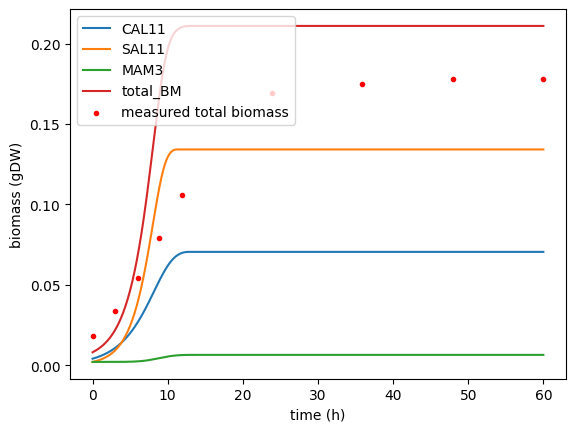

In [65]:
from functions.plot_results import plot_biomass_time_course

plot_biomass_time_course(sim.total_biomass, OD_df)

### Relative species abundance time-course
fig. 7 a

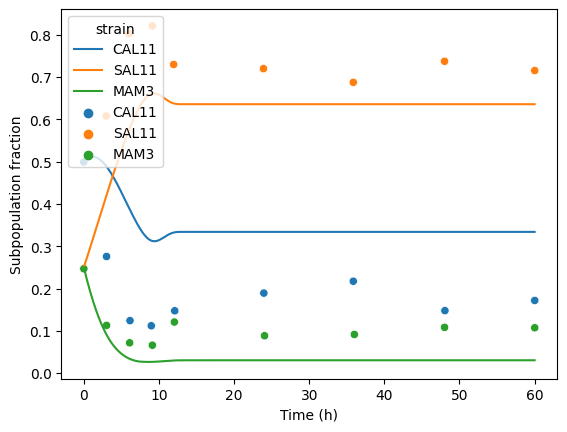

In [66]:
from functions.plot_results import plot_relative_abundance_time_course

plot_relative_abundance_time_course(sim.total_biomass, subpop_df)

### Production of CA, SAA, RA
fig 7. b

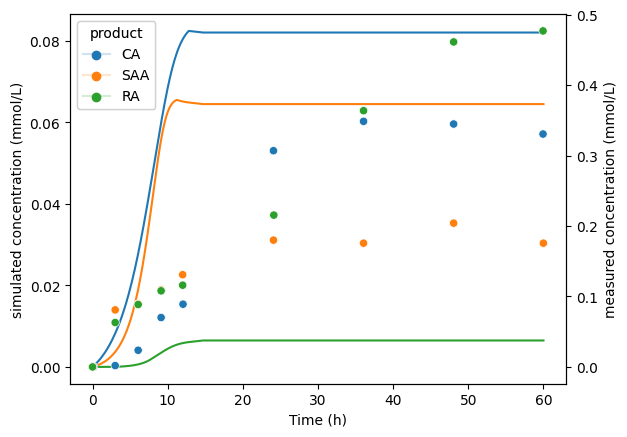

In [67]:
from functions.plot_results import plot_production_time_course

plot_production_time_course(sim.get_metabolite_time_series(), conc_df)

In [69]:
print("Total biomass g(DW):", sum(sim.total_biomass.drop(columns=["cycle"], inplace=False).iloc[-1]))
print("Total RA produced (mmol): ", sim.get_metabolite_time_series()["rosma_e"].iloc[-1])

Total biomass g(DW): 0.21093799132
Total RA produced (mmol):  0.0064885069615


### Fluxes

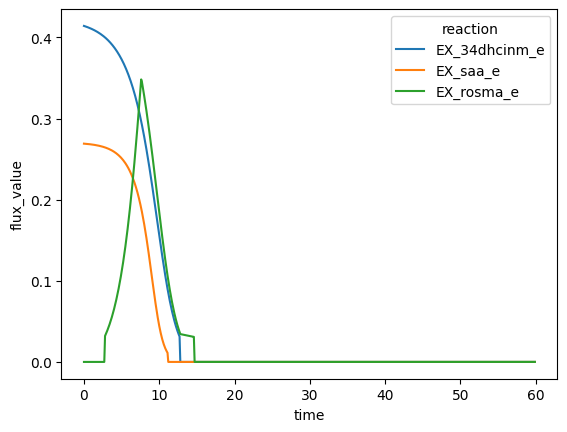

In [70]:
from functions.plot_results import plot_production_flux_values

plot_production_flux_values(sim)

### Metabolites

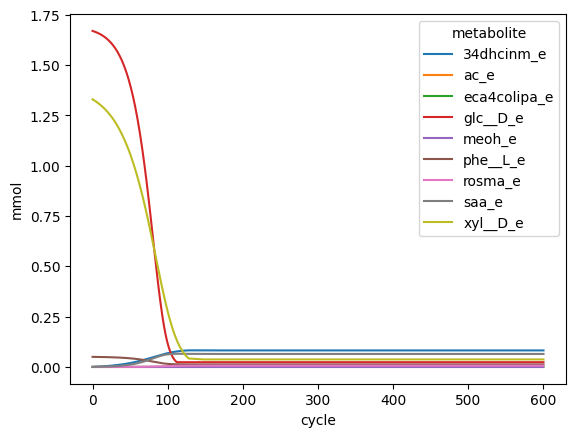

In [71]:
from functions.plot_results import plot_metabolites

plot_metabolites(sim)

### Inoculation ratio and glucose / xylose ratio
load results from the pairwise comparison (run the program from terminal)

In [76]:
%load_ext autoreload

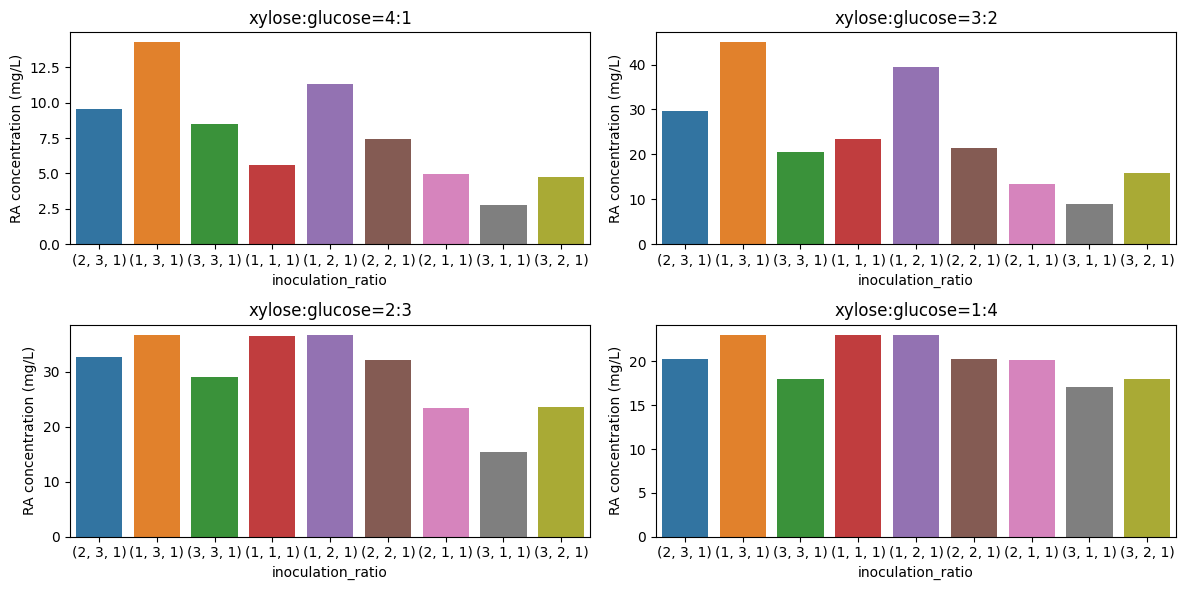

In [78]:
%autoreload

from functions.plot_results import plot_inoculum_substrate, get_best_performing_combo
import pandas as pd

result_filepath = "results/fig_6"

inoculum_substrate_results = pd.read_csv(result_filepath)

plot_inoculum_substrate(inoculum_substrate_results)

In [79]:
get_best_performing_combo(inoculum_substrate_results)

The highest RA production with the combination:
 inoculation_ratio    (1, 3, 1)
glc_xyl_ratio           (2, 3)
total_biomass         0.206861
total_RA              0.012468
RA_concentration     44.924415
Name: 5, dtype: object
